<a href="https://colab.research.google.com/github/calvinpozderac/2D-Electron-Hydrodynamics-Dedalus-PDE/blob/main/Dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Check Dedalus isn't already installed
## Installation takes about 1-2 mins

try:
    import dedalus.public as de
    print("Dedalus already installed")
except:
    print("Dedalus not installed yet. Let's do it.")

# Step 1: Install FFTW
!apt-get install libfftw3-dev
!apt-get install libfftw3-mpi-dev

# Step 2: Set paths for Dedalus installation
import os
os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

# Step 3: Install Dedalus using pip
!pip3 install dedalus
!pip3 uninstall dedalus -y
!CC=mpicc pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/

# Step 4: Check Dedalus is importable
print()
print()
try:
    import dedalus.public as de
    print("Dedalus successfully installed :)")
except:
    print("Error installing Dedalus :(")
    raise


Dedalus not installed yet. Let's do it.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-single3 amd64 3.3.8

2023-09-19 17:47:30,318 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.


2023-09-19 17:47:30,323 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-09-19 17:47:30,551 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.
Dedalus successfully installed :)


In [ ]:
!export OMP_NUM_THREADS=1
!export NUMEXPR_MAX_THREADS=1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
logging.getLogger().setLevel(logging.WARNING)

def loop(mat):
    mat = np.vstack([mat, mat[0].reshape(1,len(mat[0]))])
    mat = np.hstack([mat, mat[:,0].reshape(len(mat[:,0]),1)])
    return mat

def solveNS(disorder, kappa, Nx, Ny, dn0, ds0,zeta, thermo = 1):
    # Parameters

    n0 = s0 = 1
    #dn0 = ds0 = 0.2
    T0 = 1
    nu = 1
    m = 1
    xi = 1
    E = 1
    #zeta = 0
    #kappa = 10**-8


    #Lx, Ly = xi, xi
    #Nx, Ny = 2**8, 2**8
    dtype = np.float64



    # Bases
    coords = d3.CartesianCoordinates('x', 'y')
    dist = d3.Distributor(coords, dtype=dtype)
    xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
    ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

    # Fields
    u = dist.VectorField(coords, name='u', bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis, ybasis))
    T = dist.Field(name='T', bases=(xbasis, ybasis))
    V = dist.Field(name='V', bases=(xbasis, ybasis))

    tau_p = dist.Field(name='tau_p', bases=ybasis)
    tau_T = dist.Field(name='tau_T', bases=ybasis)
    tau_V = dist.Field(name='tau_V', bases=ybasis)

    # Forcing
    x, y = dist.local_grids(xbasis, ybasis)

    n = dist.Field(bases=(xbasis, ybasis))
    n['g'] = n0 + dn0*disorder(x,y)

    n2 = dist.Field(bases=(xbasis, ybasis))
    n2['g'] = (n0 + dn0*disorder(x,y))**2


    s = dist.Field(bases=(xbasis, ybasis))
    s['g'] = s0 + ds0*disorder(x,y)

    ex, ez = coords.unit_vector_fields(dist)

    # Problem

    problem = d3.LBVP([u, p, T, tau_p, tau_T], namespace=locals())
    problem.add_equation("div(n*u) +tau_p= 0")
    problem.add_equation("m*n*((0*nu+zeta)*grad(div(u)) + nu*div(grad(u))) - grad(p) - thermo*n2*grad(T) =  -n*E*ex ")
    problem.add_equation("kappa*lap(T) - m*n*T0*u@grad(s)+tau_T = 0")

    problem.add_equation("p(x=0) = 0")
    problem.add_equation("T(x=0) = 0")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Gather global data
    x = xbasis.global_grid()
    y = ybasis.global_grid()
    uxg, uyg = u.allgather_data('g')
    uxg = uxg.T
    uyg = uyg.T
    pg = p.allgather_data('g').T
    Tg = T.allgather_data('g').T
    #Vg = V.allgather_data('g').T
    return uxg, uyg, pg, Tg

In [ ]:
xi = 1
Lx, Ly = xi, xi
Nx, Ny = 2**7, 2**7
n0 = s0 = 1
dn0 = ds0 = 0.1
T0 = 1
nu = 1
m = 1
xi = 1
E = 1
zeta = 0
kappas = np.logspace(-5, -9, 3)
all_jxs = []
all_jys = []
all_Is = []
all_js = []
all_ns = []
all_maxjs = []
alphas = []

disorder_funcs = [lambda x,y: np.cos(2*np.pi*x/xi)*np.cos(2*np.pi*y/xi),
                  lambda x,y: 1/np.sqrt(6)*(2*(np.sin((2*np.pi*(y -1/4))/xi)*np.cos((2*np.pi*x)/xi)) - np.cos(3*np.pi/6 + np.pi*(4*(y - 1/4))/xi)),
                  lambda x,y: 1/np.sqrt(6)*(2*(np.sin((2*np.pi*(y - 1/4))/xi)*np.cos((2*np.pi*x)/xi)) - np.cos(3*0 + np.pi*(4*(y - 1/4))/xi))]
ts = [0, np.pi/6, 0]
scales = [1,np.sqrt(3),np.sqrt(3)]
for disorder_func in disorder_funcs:
    jxs = []
    jys = []
    Is = []
    js = []
    X, Y = np.meshgrid(np.linspace(0, Lx, Nx+1)[:-1],np.linspace(0, Ly, Ny+1)[:-1])
    n = n0 + dn0*disorder_func(X,Y)
    maxj = 0
    for kappa in kappas:
        uxg, uyg, pg, Tg = solveNS(disorder_func, kappa,Nx,Ny,dn0,ds0, zeta)
        jx = n*uxg
        jy = n*uyg
        I = np.sum(jx[:,0]*Ly/Ny)
        j = np.sqrt(jx**2+jy**2)

        maxj = max(maxj, np.max(j/I))

    all_maxjs.append(maxj)

1.893001013333315 6.258388519287109
2.0262552309223487 14.384908199310303
1.6072700125904862 7.127748489379883
4.736326144979767 5.382121562957764
3.5673309569959364 15.416441440582275
3.4986116118706327 7.53777003288269
10.010635044023333 5.572969436645508
6.337798500268921 15.31861138343811
7.332681310232121 7.573092937469482


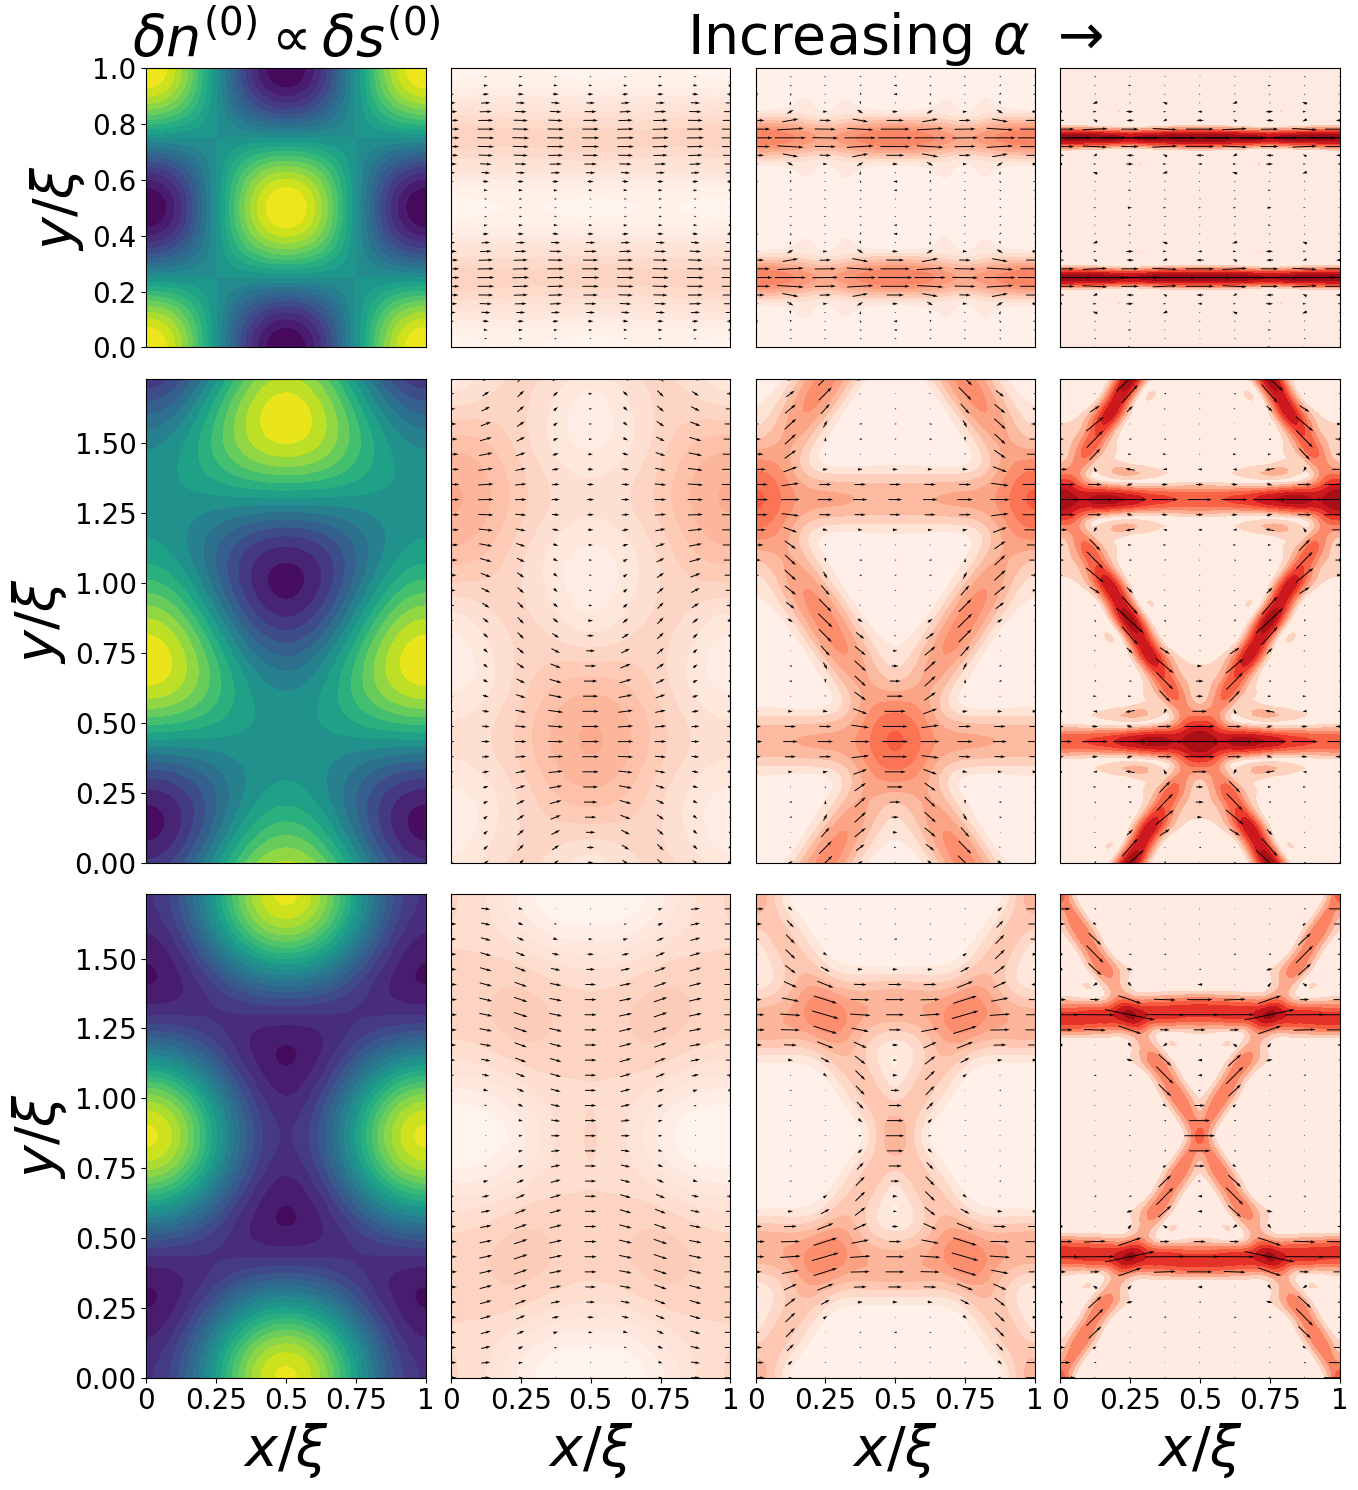

In [ ]:
import time
import gc

ny = len(disorder_funcs)
nx = len(kappas)+1
fig, axes = plt.subplots(ny, nx, figsize = (3*nx+0.4,3*(1+(ny-1)*np.sqrt(3))),gridspec_kw={'height_ratios': [1, np.sqrt(3),np.sqrt(3)]})
fig.tight_layout(pad=0.01)
scales = [1,np.sqrt(3),np.sqrt(3)]


Nx, Ny = 2**7, 2**7
dx = int(Nx/8)
dy = int(Ny/32)


X, Y = np.meshgrid(np.linspace(0, Lx, Nx+1),np.linspace(0, Ly, Ny+1))


disorder_funcs = [lambda x,y: np.cos(2*np.pi*x/xi)*np.cos(2*np.pi*y/xi),
                  lambda x,y: 1/np.sqrt(6)*(2*(np.sin((2*np.pi*(y -1/4))/xi)*np.cos((2*np.pi*x)/xi)) - np.cos(3*np.pi/6 + np.pi*(4*(y - 1/4))/xi)),
                  lambda x,y: 1/np.sqrt(6)*(2*(np.sin((2*np.pi*(y - 1/4))/xi)*np.cos((2*np.pi*x)/xi)) - np.cos(3*0 + np.pi*(4*(y - 1/4))/xi))]
ts = [0, np.pi/6, 0]
scales = [1,np.sqrt(3),np.sqrt(3)]

j_avg = []
jx_avg = []

for k in range(ny):
    ax = axes[k, 0]
    ax.set_anchor('W')
    ax.set_aspect(1)
    n = n0 + dn0*disorder_funcs[k](X,Y)
    ax.contourf(X,scales[k]*Y, n, cmap = "viridis", levels = 20)
    if k!=ny-1:
        ax.set_xticks([])
    else:
        ax.set_xlabel(r"$x/\xi$", fontsize = 40)
        ax.tick_params(axis='x', labelsize=20)
        ax.set_xticks([0,1/4, 1/2, 3/4, 1])
        ax.set_xticklabels(["0","0.25","0.5", "0.75", "1"])

    if k==0:
        ax.set_title(r"$\delta n^{(0)} \propto \delta s^{(0)}$", fontsize = 40)
    ax.set_ylabel(r"$y/\xi$", fontsize = 40)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlim(0, np.max(X))

for k in range(0*ny):
    ax = axes[k, -1]
    ax.set_anchor('W')
    ax.set_aspect(1)
    kappa = kappas[-1]
    if scales[k] == 1:
        w = min_w_square(n0, dn0, ds0, m, T0, kappa)
    else:
        w = min_w_moire(n0, dn0, ds0, m, T0, kappa,ts[k])

    maxj = all_maxjs[k]
    j = lambda x,y: np.maximum(-3*((y%(scales[k]*Ly/2)-scales[k]*Ly/4)**2-w**2/4)/w**3,0)
    ax.contourf(X,scales[k]*Y, j(X, scales[k]*Y), cmap = "Reds", vmin = 0, vmax = maxj)
    ax.quiver(X[::dx,::dy],scales[k]*Y[::dx,::dy], j(X, scales[k]*Y)[::dx,::dy] , np.zeros_like(X[::dx,::dy]) , color = 'k', pivot = "mid")
    if k!=ny-1:
        ax.set_xticks([])
    else:
        ax.set_xlabel(r"$x/\xi$", fontsize = 40)
        ax.tick_params(axis='x', labelsize=20)
        ax.set_xticks([0,1/4, 1/2, 3/4, 1])
        ax.set_xticklabels(["0","0.25","0.5", "0.75", "1"])

    if k==0:
        ax.set_title("Variational\n Solution", fontsize = 40)
    ax.set_yticks([])
    ax.set_xlim(0, np.max(X))

for i,kappa in enumerate(kappas):
    for k in range(ny):
        start = time.time()
        ax = axes[k, i+1]
        ax.set_anchor('W')


        disorder_func = disorder_funcs[k]
        n = n0 + dn0*disorder_func(X,Y)
        uxg, uyg, pg, Tg = solveNS(disorder_func, kappa,Nx,Ny,dn0,ds0, zeta)
        jx = n*loop(uxg)
        jy = n*loop(uyg)
        I = np.sum(jx[:,0]*Ly/Ny)
        j = np.sqrt(jx**2+jy**2)
        maxj = 1.1*all_maxjs[k]
        print(np.max(j/I), time.time()-start)

        if k == 0:
            jx_avg.append(np.mean(jx,axis = 1)/I)
            j_avg.append(np.mean(j,axis = 1)/I)


        ax.set_aspect(1)
        ax.set_ylim(0, scales[k]*np.max(Y))
        ax.set_xlim(0, np.max(X))

        ax.set_yticks([])
        if k!=ny-1:
            ax.set_xticks([])
        else:
            ax.set_xlabel(r"$x/\xi$", fontsize = 40)
            ax.tick_params(axis='x', labelsize=20)
            ax.set_xticks([0,1/4, 1/2, 3/4, 1])
            ax.set_xticklabels(["0","0.25","0.5", "0.75", "1"])
        if k==0:
            variable_text = str(int(np.log10(kappa)))
            #ax.set_title(r"$\kappa=10^{%(exp)s}$"%{"exp":int(np.log10(kappa))}, fontsize = 25)
            if i == 1:
                ax.set_title(r"Increasing $\alpha$ $\rightarrow$", fontsize = 40)


        ax.contourf(X,scales[k]*Y, j/I, cmap = "Reds", vmin = 0, vmax = maxj)
        #ax.streamplot(X,scales[k]*Y, loop(jx) , loop(jy) , color = 'k', linewidth = 50*loop(j)/I, arrowsize =0.75, density = 2)
        ax.quiver(X[::dy,::dx],scales[k]*Y[::dy,::dx], jx[::dy,::dx] , jy[::dy,::dx] , color = 'k', pivot = "mid")#, linewidth = 50*loop(j)/I, arrowsize =0.75, density = 2)
        gc.collect()
plt.subplots_adjust(wspace=0.075, hspace=0.075)
plt.savefig("current_density_grid.pdf",bbox_inches = "tight")
plt.show()

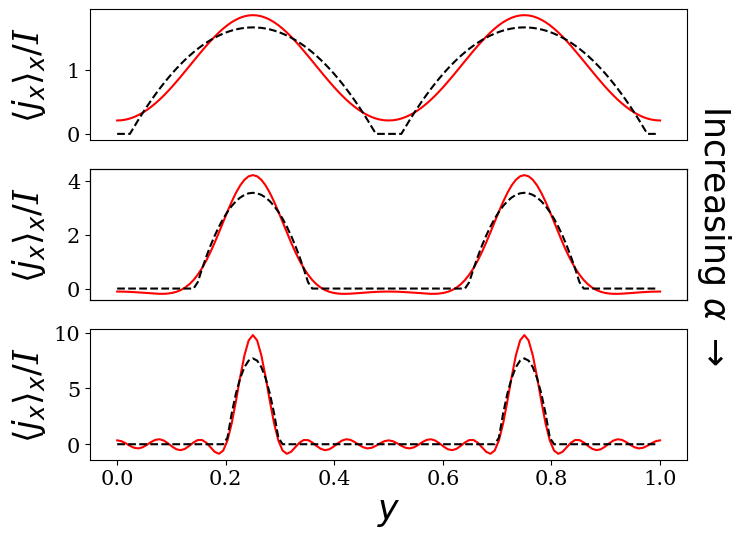

In [ ]:

def min_w_square(n0, dn0, ds0, m, T0, kappa):
    return xi*(24/(np.pi**4/35))**(1/6) *((kappa *nu)/(ds0**2 * m * n0 * T0 * xi**2))**(1/6)
    #return (2**(1/3) *105**(1/6) *((kappa *nu *xi**4)/(ds0**2* m *n0 *T0))**(1/6))/np.pi**(2/3)

import matplotlib as mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman'] + plt.rcParams['font.serif']

fig, axes = plt.subplots(3, 1)
fig.tight_layout(pad=0.01)
colors = ['r', 'r', 'r']
k = 0
for i in range(3):
    if i == 2:
        axes[i].set_xlabel(r"$y$", fontsize = 25)
        axes[i].tick_params(axis='x', labelsize=15)
    else:
        axes[i].set_xticks([])
    mpl.rcParams.update(mpl.rcParamsDefault)

    axes[i].tick_params(axis='y', labelsize=15)
    #axes[i].plot(Y[:, Nx//2][:-1],np.array(all_jxs)[0,i,:,0]/all_Is[k][i], c = colors[i])
    #axes[i].set_ylabel(r"$j_x(x = L_x/2) /I$")
    #axes[i].plot(Y[:, Nx//2][:-1],np.array(all_js)[0,i,:,0]/all_Is[k][i], c = colors[i])
    #axes[i].set_ylabel(r"$|j(x=0)|$/I")
    #axes[i].set_ylabel(r"$j_x(x = 0) /I$")
    #axes[i].plot(Y[:, Nx//2][:-1],np.mean(all_jxs[k][i],axis = 1)/all_Is[k][i], c = colors[i])
    axes[i].plot(Y[:, Nx//2],jx_avg[i], c = colors[i])
    axes[i].set_ylabel(r"$\langle j_x \rangle_x/$I",  style='italic', fontsize = 25)
    #axes[i].set_ylabel(r"$\langle j_x \rangle_y$/I")
    #plt.plot(Y[:, Nx//2][:-1],-10*i+all_jys[k][i][:,0]/all_Is[k][i], c = colors[i])
    kappa = kappas[i]
    if scales[k] == 1:
        w = min_w_square(n0, dn0, ds0, m, T0, kappa)
    else:
        w = min_w_moire(n0, dn0, ds0, m, T0, kappa,ts[k])
    j = lambda x,y: np.maximum(-3*((y%(scales[k]*Ly/2)-scales[k]*Ly/4)**2-w**2/4)/w**3,0)
    axes[i].plot(Y[:, Nx//2][:-1],j(X[:, Nx//2][:-1], scales[k]*Y[:, Nx//2][:-1]), 'k--')
    fig.align_ylabels()
    if i==1:
        axR = axes[1].twinx()
        axR.set_yticks([])
        axR.yaxis.set_label_position("right")
        axR.set_ylabel(r"$\mathrm{Increasing}$ $\alpha$ $\rightarrow$", rotation=-90, labelpad=33, fontsize = 25)
plt.savefig("variational.pdf",bbox_inches = "tight")
plt.show()